<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/13_poetry_model_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [11]:
#hide
from fastbook import *
from IPython.display import display,HTML
from google.colab.patches import cv2_imshow
from fastai.text.all import *

# Lorca Poem creator from scratch

Lorca was without doubt, one of the most important poets in the history of spanish literature, in the following notebook, we will learn from his whole masterpiece and generate poetry "a lo Lorca". By doing so we will leverage the learning from the nlp deep dive of fastai and the study of RNNs and LSTMS.

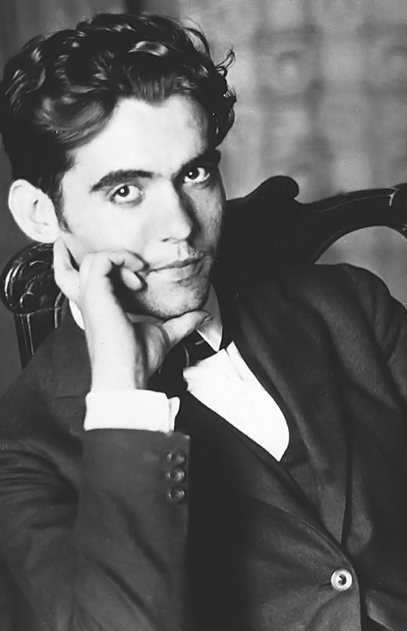

In [3]:
import cv2
img = cv2.imread('/content/gdrive/MyDrive/lorca/garcia_lorcaGR (1).jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

We will first process all his poems from that pdf

In [4]:
!pip install tika

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tika import parser # pip install tika
raw = parser.from_file('/content/gdrive/MyDrive/lorca/federico-garcc3ada-lorca-obras-completas.pdf')

In [3]:
txt = raw['content']; txt[:1000]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nObras Completas\n\n\n\n\nAnnotation\n\nFederico\tGarcía\tLorca,\t uno\t de\t los\t poetas\tmás\t insignes\t de\t nuestra\t época,\t nació\t en\n1898,\t en\t Fuente\t Vaqueros\t (Granada)\t y\t murió\t fusilado\t por\t los\t rebeldes\t en\t 1936,\t al\ncomienzo\t de\t la\t Guerra\t Civil\t española.\t Desde\t que,\t en\t 1918,\t publicara\t su\t primer\t libro\nImpresiones\t y\t paisajes,\t escribió\t y\t publicó\t numerosas\t obras\t de\t poesía,\t drama\t y\t prosa,\nalgunas\tde\tlas\tcuales\tfueron\tinterrumpidas\tpor\tsu\tmuerte.\n\nEn\t esta\t recopilación\t de\t Obras\t Completas\t se\t han\t tomado\t como\t base\t las\t Obras\nCompletas\tde\tFederico\tGarcía\tLorca\tde\tla\tweb:\n\nhttp://www.culturandalucia.com/FEDERICO_GARCIA_LORCA/Federico_Garcia_Lorca_Obras.htm\n\nTambién\tse\than\ttenido\ten\tcuenta\tlos\tcontenidos\tsobre\tLorca\tde\tlos\tsitios:\thttp://fac-\nweb.spsu.edu,\thttp://www.

We will perform some replacements to ensure the punktuation is treated as a separate token, and parenthesis and claudators are not considered.

In [4]:
tokens = txt.replace('[',"")
tokens = tokens.replace(']',"")
tokens = tokens.replace('(',"")
tokens = tokens.replace(')',"")
tokens = tokens.replace('.'," .")
tokens = tokens.replace(';'," ;")
tokens = tokens.replace(','," ,")
tokens[:1000]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nObras Completas\n\n\n\n\nAnnotation\n\nFederico\tGarcía\tLorca ,\t uno\t de\t los\t poetas\tmás\t insignes\t de\t nuestra\t época ,\t nació\t en\n1898 ,\t en\t Fuente\t Vaqueros\t Granada\t y\t murió\t fusilado\t por\t los\t rebeldes\t en\t 1936 ,\t al\ncomienzo\t de\t la\t Guerra\t Civil\t española .\t Desde\t que ,\t en\t 1918 ,\t publicara\t su\t primer\t libro\nImpresiones\t y\t paisajes ,\t escribió\t y\t publicó\t numerosas\t obras\t de\t poesía ,\t drama\t y\t prosa ,\nalgunas\tde\tlas\tcuales\tfueron\tinterrumpidas\tpor\tsu\tmuerte .\n\nEn\t esta\t recopilación\t de\t Obras\t Completas\t se\t han\t tomado\t como\t base\t las\t Obras\nCompletas\tde\tFederico\tGarcía\tLorca\tde\tla\tweb:\n\nhttp://www .culturandalucia .com/FEDERICO_GARCIA_LORCA/Federico_Garcia_Lorca_Obras .htm\n\nTambién\tse\than\ttenido\ten\tcuenta\tlos\tcontenidos\tsobre\tLorca\tde\tlos\tsitios:\thttp://fac-\nweb .spsu .edu

In [5]:
tokens = tokens.split()

In [12]:
vocab = L(*tokens).unique()
vocab


(#33913) ['Obras','Completas','Annotation','Federico','García','Lorca',',','uno','de','los'...]

I could not find a good rule of thumb to define the right sequence length. But considering we are working with poems, 40 tokens seems like a sufficiently long sequence. We will work directly for bigger sequence as the ones from the fastai course of 3-4 tokens is just too short for the complicated task, if no impossible, to model poetry.

In [13]:
seql = 40

We assign next to each token a number

In [14]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#340163) [0,1,2,3,4,5,6,7,8,9...]

We create sequences of the desired length, creating also the target variable as the next token.

In [15]:
seqs = L((tensor(nums[i:i+seql]), nums[i+seql]) for i in range(0,len(nums)-seql-1,seql))
seqs[1]

(tensor([32, 33, 34, 35,  6, 16, 36,  6, 37, 38, 39, 40, 41, 21, 42,  6, 43, 21, 44, 45, 46,  8, 47,  6, 48, 21, 49,  6, 50,  8, 51, 52, 53, 54, 24, 38, 55, 33, 56, 57]),
 58)

In [16]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

Our first model will be a shallow recurrent neural network, where we add an embedding layer to each new token. Note that the state h is reset to zero every sequence, so we are not properly managing memory, yet...

### Shallow RNN, without state

In [17]:
class LMModel(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        h = 0
        for i in range(seql):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

In [18]:
learn = Learner(dls, LMModel(len(vocab), 32), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.710396,7.693944,0.039389,00:12
1,6.206300,7.919579,0.051734,00:10
2,4.954338,8.499366,0.062904,00:10
3,4.540378,8.741817,0.057613,00:10


We will compare the accuracy against the one of predicting the most common token, as a baseline.

In [19]:
n,counts = 0,torch.zeros(len(vocab))
for x,y in dls.valid:
    n += y.shape[0]
    for i in range_of(vocab): counts[i] += (y==i).long().sum()
idx = torch.argmax(counts)
idx, vocab[idx.item()], counts[idx].item()/n

(tensor(6), ',', 0.053497942386831275)

We can see that we are only as good as our naive classifier that predict the most common token, which is a comma. We will be improving our model to get to significantly better results next.

### Updating the State

Note from LMModel that we are initializing our hidden state to zero for every new input sequence. Why is that a problem? We made our sample sequences short so they would fit easily into batches. But if we order the samples correctly, those sample sequences will be read in order by the model, exposing the model to long stretches of the original sequence.

Because we initialize the model's hidden state to zero for each new sample, we are throwing away all the information we have about the sentences we have seen so far, which means that our model doesn't actually know where we are up to in the overall counting sequence. This is easily fixed; we can simply move the initialization of the hidden state to __init__.

But this fix will create its own subtle, but important, problem. It effectively makes our neural network as deep as the entire number of tokens in our document. For instance, if there were 10,000 tokens in our dataset, we would be creating a 10,000-layer neural network.

The problem with a 10,000-layer neural network is that if and when you get to the 10,000th word of the dataset, you will still need to calculate the derivatives all the way back to the first layer. This is going to be very slow indeed, and very memory-intensive. It is unlikely that you'll be able to store even one mini-batch on your GPU.

The solution to this problem is to tell PyTorch that we do not want to back propagate the derivatives through the entire implicit neural network. Instead, we will just keep the last three layers of gradients. To remove all of the gradient history in PyTorch, we use the detach method.

Here is the new version of our RNN. It is now stateful, because it remembers its activations between different calls to forward, which represent its use for different samples in the batch:

In [20]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        for i in range(seql):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

To use LMModel2, we need to make sure the samples are going to be seen in a certain order. If the first line of the first batch is our dset[0] then the second batch should have dset[1] as the first line, so that the model sees the text flowing.

To do this, we are going to rearrange our dataset. First we divide the samples into m = len(dset) // bs groups (this is the equivalent of splitting the whole concatenated dataset into, for example, 64 equally sized pieces, since we're using bs=64 here). m is the length of each of these pieces. For instance, if we're using our whole dataset (although we'll actually split it into train versus valid in a moment), that will be:

In [21]:
m = len(seqs)//bs
m,bs,len(seqs)

(132, 64, 8504)

In [22]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

Then we just pass drop_last=True when building our DataLoaders to drop the last batch that does not have a shape of bs. We also pass shuffle=False to make sure the texts are read in order:

In [23]:
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

In [24]:
learn_s = Learner(dls, LMModel2(len(vocab), 64), loss_func=F.cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
learn_s.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,10.373106,9.694656,0.040264,00:17
1,7.429704,7.850888,0.045072,00:17
2,6.377370,7.954510,0.051683,00:16
3,6.080598,8.023977,0.052284,00:16


It already get better only in the validation loss thought,this is not suprising as the poetry may not require to keep a large memory. Due to the fact that we only learn from the output loss, we will now allow the model to learn from its intermmediate outputs.

### Creating more signal

Another problem with our current approach is that we only predict one output word for each forty input words. That means that the amount of signal that we are feeding back to update weights with is not as large as it could be. It would be better if we predicted the next word after every single word

In [25]:
sl = 40
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

In [26]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#40) ['Obras','Completas','Annotation','Federico','García','Lorca',',','uno','de','los'...],
 (#40) ['Completas','Annotation','Federico','García','Lorca',',','uno','de','los','poetas'...]]

Now we need to modify our model so that it outputs a prediction after every word, rather than just at the end of the sequence:

In [27]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h)) # output a prediction after each word
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self): self.h = 0

This model will return outputs of shape bs x sl x vocab_sz (since we stacked on dim=1). Our targets are of shape bs x sl, so we need to flatten those before using them in F.cross_entropy:

In [28]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [29]:
learn_ms = Learner(dls, LMModel3(len(vocab), 64), loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
learn_ms.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,9.658136,8.419626,0.027960,02:19
1,7.397789,7.469214,0.056731,02:18
2,6.720788,7.285200,0.066166,02:18
3,6.305849,7.224907,0.070358,02:18
4,6.003513,7.264482,0.073768,02:17
5,5.766936,7.349950,0.076397,02:18
6,5.580945,7.357705,0.078320,02:16
7,5.443880,7.396673,0.080048,02:21
8,5.354697,7.419505,0.081866,02:19
9,5.314182,7.451836,0.082317,02:15


We need to train for longer, since the task has changed a bit and is more complicated now.

Now, the obvious way to get a better model is to go deeper: we only have one linear layer between the hidden state and the output activations in our basic RNN, so maybe we'll get better results with more.

### Multilayer RNNs

In a multilayer RNN, we pass the activations from our recurrent neural network into a second recurrent neural network.We can save some time by using PyTorch's RNN class, which implements exactly what we created earlier, but also gives us the option to stack multiple RNNs, as we have discussed:

In [30]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True) #this is how we make the rnn deeper
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h) # adding deep recurrent rnns
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [31]:
learn_drn = Learner(dls, LMModel4(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn_drn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,9.365212,7.952348,0.057497,01:36
1,7.452592,7.546628,0.038657,01:36
2,7.145340,7.437026,0.041617,01:35
3,6.824267,7.166115,0.065024,01:36
4,6.506645,7.039872,0.071319,01:37
5,6.280645,6.970101,0.075856,01:35
6,6.127292,6.934744,0.078846,01:36
7,6.028962,6.920583,0.082843,01:36
8,5.971753,6.936048,0.080018,01:35
9,5.945373,6.929245,0.080303,01:36


Why is not performing better than the shallow RNN? The reason is that we have a deeper model, leading to exploding or vanishing activations. As we saw in the previous post: [RNNs theory](https://alanfortunysicart.blogspot.com/2022/09/fastai-deeplearning-part-131-nlp-deep.html), LSTMs help to avoid catastrophic forgetting or vanishing gradients.

Here we using from scratch implementation, but note that during training we will be using the Pytorch LSTMs directly.

In [32]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni + nh, nh)
        self.input_gate  = nn.Linear(ni + nh, nh)
        self.cell_gate   = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)

    def forward(self, input, state):
        h,c = state
        h = torch.cat([h, input], dim=1)
        forget = torch.sigmoid(self.forget_gate(h))
        c = c * forget
        inp = torch.sigmoid(self.input_gate(h))
        cell = torch.tanh(self.cell_gate(h))
        c = c + inp * cell
        out = torch.sigmoid(self.output_gate(h))
        h = out * torch.tanh(c)
        return h, (h,c)

In [33]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [34]:
learn_LSTM = Learner(dls, LMModel6(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn_LSTM.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.408876,7.500185,0.038732,01:39
1,7.397027,7.702305,0.038717,01:38
2,7.373963,7.872714,0.038687,01:39
3,7.266475,7.513526,0.038732,01:38
4,6.866013,7.192980,0.061388,01:38
5,6.511758,7.094612,0.065189,01:39
6,6.259635,7.016843,0.072716,01:39
7,6.072375,6.998538,0.079327,01:38
8,5.932728,6.985023,0.083774,01:40
9,5.825276,6.954877,0.087755,01:39


We got the best result so far, 100% better than the baseline model. Let's see how can we reduce the amount of overfitting observed.

### Ad Dropout!

Recurrent neural networks, in general, are hard to train, because of the problem of vanishing activations and gradients we saw before. Using LSTM (or GRU) cells makes training easier than with vanilla RNNs, but they are still very prone to overfitting. 

However, there are regularization techniques we can use instead to reduce overfitting, which were thoroughly studied for use with LSTMs in the paper "Regularizing and Optimizing LSTM Language Models" by Stephen Merity, Nitish Shirish Keskar, and Richard Socher. This paper showed how effective use of dropout, activation regularization, and temporal activation regularization could allow an LSTM to beat state-of-the-art results that previously required much more complicated models. The authors called an LSTM using these techniques an AWD-LSTM.



### Main idea behind Dropout

Dropout is a regularization technique that was introduced by Geoffrey Hinton et al. in Improving neural networks by preventing co-adaptation of feature detectors. The basic idea is to randomly change some activations to zero at training time. This makes sure all neurons actively work toward the output.

We can see, however, that if we were to just zero those activations without doing anything else, our model would have problems training: if we go from the sum of five activations (that are all positive numbers since we apply a ReLU) to just two, this won't have the same scale. Therefore, if we apply dropout with a probability p, we rescale all activations by dividing them by 1-p (on average p will be zeroed, so it leaves 1-p)

In [36]:
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-p)
        return x * mask.div_(1-p)

Dropout has different behavior in training and validation mode, which we specified using the training attribute in Dropout. Calling the train method on a Module sets training to True (both for the module you call the method on and for every module it recursively contains), and eval sets it to False

In [40]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p) #dropout as explained before
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight #weight tying
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

### Two important regularizations: activation regularization and temporal regularization



1.   Activation Regularization : we add a small penalty to the loss that aims at making the weights as small as possible. For activation regularization, it's the final activations produced by the LSTM that we will try to make as small as possible, instead of the weights. Applied with paremeter alpha.
2.   Temporal activation regularization is linked to the fact we are predicting tokens in a sentence. That means it's likely that the outputs of our LSTMs should somewhat make sense when we read them in order. TAR is there to encourage that behavior by adding a penalty to the loss to make the difference between two consecutive activations as small as possible. Applied with parameter beta. 

Another useful trick we can add from the AWD LSTM paper is weight tying. In a language model, the input embeddings represent a mapping from  words to activations, and the output hidden layer represents a mapping from activations to words. We might expect, intuitively, that these mappings could be the same. We can represent this in PyTorch by assigning the same weight matrix to each of these layers:

self.h_o.weight = self.i_h.weight

In [ ]:
# DO NOT RUN : THIS IS JUST TO ILLUSTRATE HOW THE TEXT LEARNER BELLOW HAVE THE REGULARIZATIONS EXPLAIN WITH ALPHA 2 AND BETA 1 AS DEFAULT
#learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
#                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
#                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

In [44]:
learn_D = TextLearner(dls, LMModel7(len(vocab), 64, 2, 0.4),
                    loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [45]:
learn_D.fit_one_cycle(25, 3e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,10.270100,10.071746,0.038612,01:35
1,9.950430,9.608742,0.038762,01:37
2,9.250168,8.419702,0.053801,01:37
3,8.301715,7.528580,0.066752,01:35
4,7.671639,7.220752,0.074053,01:37
5,7.327908,7.121368,0.075916,01:37
6,7.101836,7.044969,0.083218,01:36
7,6.933478,6.981809,0.087680,01:37
8,6.799755,6.942639,0.091331,01:37
9,6.683491,6.902042,0.097431,01:36


This is so far how far we got with training a poetry model from scratch, we reach around 15% accuracy, around three times better than the baseline model. We will see as a wrap up how we boost performance using the same model explained in detail, but this time using transfer learning.

# Using tranfer learning over AWD_LSTM

We start by creating a data frame from our tokens, which will be used in the specific data block required to use the language model learner api.

In [47]:
df = pd.DataFrame({'col':tokens})

In [48]:
df = pd.DataFrame([sub.split(";") for sub in [' '.join(tokens)]])

In [49]:
df = df.transpose()


In [50]:
df['text2'] = 0

In [51]:
df.columns = ['text', 'textfalse']

In [52]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),get_x=ColReader('text'),splitter=RandomSplitter(0.2))

dls_lm = dls_lm.dataloaders(df, bs=40)
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos tuyo es . xxup mujer xxmaj tímida xxmaj estuvo con los xxunk del trigo . xxup suegra xxmaj por mí , que xxunk .se sienta . xxmaj pausa xxup mujer xxmaj el refresco . ¿ está frío ? xxup leonardo xxup sí . xxup mujer ¿ sabes que piden a mi prima ? xxup leonardo ¿ cuándo ? xxup mujer xxmaj mañana . xxmaj la boda será dentro de un mes","tuyo es . xxup mujer xxmaj tímida xxmaj estuvo con los xxunk del trigo . xxup suegra xxmaj por mí , que xxunk .se sienta . xxmaj pausa xxup mujer xxmaj el refresco . ¿ está frío ? xxup leonardo xxup sí . xxup mujer ¿ sabes que piden a mi prima ? xxup leonardo ¿ cuándo ? xxup mujer xxmaj mañana . xxmaj la boda será dentro de un mes ."
1,", todo xxbos tu madre es una gitana ” . o “ tu madre no está xxbos el otro posee en su rostro un carácter xxunk … xxmaj son xxunk . . xxmaj subimos al claustro alto , adornado xxunk con santos xxunk , cuadros antiguos y fotografías … xxmaj toca una campana grave . xxmaj cruzan los monjes la galería para ir al coro … xxmaj por una puerta se pierden","todo xxbos tu madre es una gitana ” . o “ tu madre no está xxbos el otro posee en su rostro un carácter xxunk … xxmaj son xxunk . . xxmaj subimos al claustro alto , adornado xxunk con santos xxunk , cuadros antiguos y fotografías … xxmaj toca una campana grave . xxmaj cruzan los monjes la galería para ir al coro … xxmaj por una puerta se pierden ,"


In [53]:
learn_TL = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [54]:
learn_TL.fit_one_cycle(25,1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,7.094723,6.873084,0.104642,965.922485,00:27
1,6.512260,6.146945,0.125114,467.287415,00:21
2,5.812895,5.519697,0.152632,249.559341,00:22
3,5.398479,5.286841,0.171754,197.717834,00:22
4,5.159845,5.106286,0.189412,165.056122,00:22
5,4.986001,4.964320,0.198617,143.211090,00:22
6,4.812396,4.842687,0.206709,126.809586,00:22
7,4.676730,4.761598,0.210279,116.932594,00:21
8,4.541607,4.691556,0.212302,109.022636,00:22
9,4.430286,4.643388,0.214990,103.895775,00:21


In [ ]:
TEXT = 'Viva el mar, las estrellas. Los horizontes infinitos y la lluvia suave.' 
N_WORDS = 40
N_SENTENCES = 5
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
preds

['Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Hoy perfume y de nardos , lengua comen , tú sabes que rompe una columna . El mar día . Nadie en el mundo . Cuando no se clavan inmensa tierra de tierra tierra .',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Agua y espuma , y ceniza de ceniza . Hoy musgo sobre las ondas estrellas . Agua sobre las olas . Agua estancada a los álamos . Fuente de la seda negra . Agua',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . No es posible que no florecieron . Pero no la ciudad se va y cuando el aire tú no me gusta más que el mar . No lo extraño que te gusta . y no quiero decir',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Profundo y profundo , profundo y profundo , pero un frescor de enagua . Profundo y profundo , profundo , profundo , profundo , profundo y profundo , sin que profundo , profundo , profundo , profundo ,',
 'Viva el

In [ ]:
preds

['Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Un OTOÑO en la gran sombra de la vientos . La Muerte Satán el alma del árbol . Doña Muerte , La Muerte Un Campo De Cristo',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . CANCION DIJO Rojo Un un viejo claras de la luz , y un ciencia de los silencio . Las estrellas y un campo de plata marchita . Un fondo de niebla de horas con',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Un aire en un amor y la luna que el que una mañana por la fuente del bosque de los años cadencia , y los niños y y los campos y inmortal ! Los árboles donde los mares']

# Conclusions and remarks

In the following notebook, we take advantatge of the great rnn deep drive from the FastAI book chapter 12, and apply them to a rather complex topic, such as poetry generation. Rather than aiming to find regular patterns in poetry, the goal was to validate that the improvements from RNNs showed during the course applied also here, and also to create realistic poetry based on the poems from the spanish poet Lorca. Here are the main take aways:



1.   RNNS are *deep for loops* of shallow networks over which we add tokens in order
2.   Due the large number of operations, we tend to have exploding and dissapearing gradients. 
3. To avoid the first, regularization works well on the activatio level
4. To avoid the latter and ensure memory is manage, LSTMs are good keeping the state information for relatively large sequences
5. Appliying all the tricks such as keeping but detaching the state, using deeper networks, regularization and LSTMs provide a boost in performance and increae model stability.
6. In order to get realistic poetry generation, visible in the language model accuracy, it is best to use transfer learning of a model that include all the language model tricks mentioned below. It is faster and provided to my data more than 10pp of accuracy increase or 100% improvement over my "from scratch" model.
7. The poetry generated on the best model is quite impressive, considering the model need around 20 minutes to train.  Here is one example: 

 
 *'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Tierra desgarradas como camelias grises . Por donde viven los rebaños sin raíces . Tierra , tierra sin ruido . Tierra de tierra . Tierra sin tejados . Tierra de tierra . Tierra'*

*'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Agua y espuma , y ceniza de ceniza . Hoy musgo sobre las ondas estrellas . Agua sobre las olas . Agua estancada a los álamos . Fuente de la seda negra . Agua'*










